## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [17]:

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


def build_mlp_before(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_after_input(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
            
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
"""Code Here
設定超參數
"""

LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZEs = [ 2, 16, 32, 128, 256]
MOMENTUM = 0.95

In [12]:
from keras.layers import BatchNormalization
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

model = build_mlp_after_input(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=256, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]
exp_name_tag = "after-input-batch-size-%d" % (256)
results[exp_name_tag] = {'train-loss': train_loss,
                                'valid-loss': valid_loss,
                                'train-acc': train_acc,
                                'valid-acc': valid_acc}

for BATCH_SIZE in BATCH_SIZEs:
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    exp_name_tag = "batch-size-%d" % (BATCH_SIZE)
    results[exp_name_tag] = {'train-loss': train_loss,
                                     'valid-loss': valid_loss,
                                     'train-acc': train_acc,
                                     'valid-acc': valid_acc}

model = build_mlp_before(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=256, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]
exp_name_tag = "before-batch-size-%d" % (256)
results[exp_name_tag] = {'train-loss': train_loss,
                                'valid-loss': valid_loss,
                                'train-acc': train_acc,
                                'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
batch_normalization_11 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_12 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
__________

50000/50000 [==============================] - 7s 133us/step - loss: 0.2056 - acc: 0.9456 - val_loss: 2.2012 - val_acc: 0.4795
Epoch 50/50
50000/50000 [==============================] - 7s 132us/step - loss: 0.1969 - acc: 0.9483 - val_loss: 2.1944 - val_acc: 0.4947
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
________

50000/50000 [==============================] - 172s 3ms/step - loss: 2.2442 - acc: 0.1612 - val_loss: 3.5133 - val_acc: 0.1621
Epoch 48/50
50000/50000 [==============================] - 173s 3ms/step - loss: 2.2464 - acc: 0.1617 - val_loss: 2.9371 - val_acc: 0.1670
Epoch 49/50
50000/50000 [==============================] - 171s 3ms/step - loss: 2.2414 - acc: 0.1644 - val_loss: 3.3169 - val_acc: 0.1990
Epoch 50/50
50000/50000 [==============================] - 172s 3ms/step - loss: 2.2409 - acc: 0.1647 - val_loss: 2.6046 - val_acc: 0.1647
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048 

50000/50000 [==============================] - 25s 498us/step - loss: 1.1121 - acc: 0.6051 - val_loss: 1.3388 - val_acc: 0.5280
Epoch 46/50
50000/50000 [==============================] - 25s 501us/step - loss: 1.1077 - acc: 0.6076 - val_loss: 1.3447 - val_acc: 0.5269
Epoch 47/50
50000/50000 [==============================] - 25s 492us/step - loss: 1.1011 - acc: 0.6099 - val_loss: 1.3755 - val_acc: 0.5229
Epoch 48/50
50000/50000 [==============================] - 25s 496us/step - loss: 1.1016 - acc: 0.6092 - val_loss: 1.3949 - val_acc: 0.5134
Epoch 49/50
50000/50000 [==============================] - 25s 500us/step - loss: 1.0913 - acc: 0.6130 - val_loss: 1.3652 - val_acc: 0.5252
Epoch 50/50
50000/50000 [==============================] - 25s 496us/step - loss: 1.0828 - acc: 0.6155 - val_loss: 1.3567 - val_acc: 0.5348
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072

50000/50000 [==============================] - 22s 432us/step - loss: 0.8568 - acc: 0.6935 - val_loss: 1.5846 - val_acc: 0.4918
Epoch 44/50
50000/50000 [==============================] - 22s 437us/step - loss: 0.8421 - acc: 0.6990 - val_loss: 1.6394 - val_acc: 0.4802
Epoch 45/50
50000/50000 [==============================] - 22s 436us/step - loss: 0.8356 - acc: 0.7014 - val_loss: 1.6868 - val_acc: 0.4770
Epoch 46/50
50000/50000 [==============================] - 22s 433us/step - loss: 0.8265 - acc: 0.7043 - val_loss: 1.5413 - val_acc: 0.5120
Epoch 47/50
50000/50000 [==============================] - 22s 435us/step - loss: 0.8112 - acc: 0.7097 - val_loss: 1.5250 - val_acc: 0.5182
Epoch 48/50
50000/50000 [==============================] - 22s 434us/step - loss: 0.8050 - acc: 0.7139 - val_loss: 1.4600 - val_acc: 0.5290
Epoch 49/50
50000/50000 [==============================] - 22s 437us/step - loss: 0.8006 - acc: 0.7149 - val_loss: 1.5716 - val_acc: 0.5026
Epoch 50/50
50000/50000 [=======

50000/50000 [==============================] - 10s 202us/step - loss: 0.3514 - acc: 0.8796 - val_loss: 2.3162 - val_acc: 0.4659
Epoch 42/50
50000/50000 [==============================] - 10s 198us/step - loss: 0.3447 - acc: 0.8835 - val_loss: 2.2401 - val_acc: 0.4710
Epoch 43/50
50000/50000 [==============================] - 10s 198us/step - loss: 0.3254 - acc: 0.8887 - val_loss: 2.4011 - val_acc: 0.4461
Epoch 44/50
50000/50000 [==============================] - 10s 198us/step - loss: 0.3184 - acc: 0.8919 - val_loss: 2.4707 - val_acc: 0.4519
Epoch 45/50
50000/50000 [==============================] - 10s 201us/step - loss: 0.3088 - acc: 0.8940 - val_loss: 2.4931 - val_acc: 0.4562
Epoch 46/50
50000/50000 [==============================] - 10s 199us/step - loss: 0.2984 - acc: 0.8996 - val_loss: 2.3363 - val_acc: 0.4719
Epoch 47/50
50000/50000 [==============================] - 10s 199us/step - loss: 0.2882 - acc: 0.9025 - val_loss: 2.5851 - val_acc: 0.4558
Epoch 48/50
50000/50000 [=======

50000/50000 [==============================] - 7s 133us/step - loss: 0.2997 - acc: 0.9090 - val_loss: 2.1315 - val_acc: 0.4725
Epoch 40/50
50000/50000 [==============================] - 7s 134us/step - loss: 0.2842 - acc: 0.9142 - val_loss: 2.3356 - val_acc: 0.4494
Epoch 41/50
50000/50000 [==============================] - 7s 133us/step - loss: 0.2670 - acc: 0.9201 - val_loss: 2.5476 - val_acc: 0.4377
Epoch 42/50
50000/50000 [==============================] - 7s 134us/step - loss: 0.2508 - acc: 0.9265 - val_loss: 2.2057 - val_acc: 0.4724
Epoch 43/50
50000/50000 [==============================] - 7s 133us/step - loss: 0.2370 - acc: 0.9314 - val_loss: 2.3189 - val_acc: 0.4708
Epoch 44/50
50000/50000 [==============================] - 7s 133us/step - loss: 0.2249 - acc: 0.9357 - val_loss: 2.3153 - val_acc: 0.4669
Epoch 45/50
50000/50000 [==============================] - 7s 134us/step - loss: 0.2148 - acc: 0.9386 - val_loss: 2.2923 - val_acc: 0.4788
Epoch 46/50
50000/50000 [==============

UnboundLocalError: local variable 'x' referenced before assignment

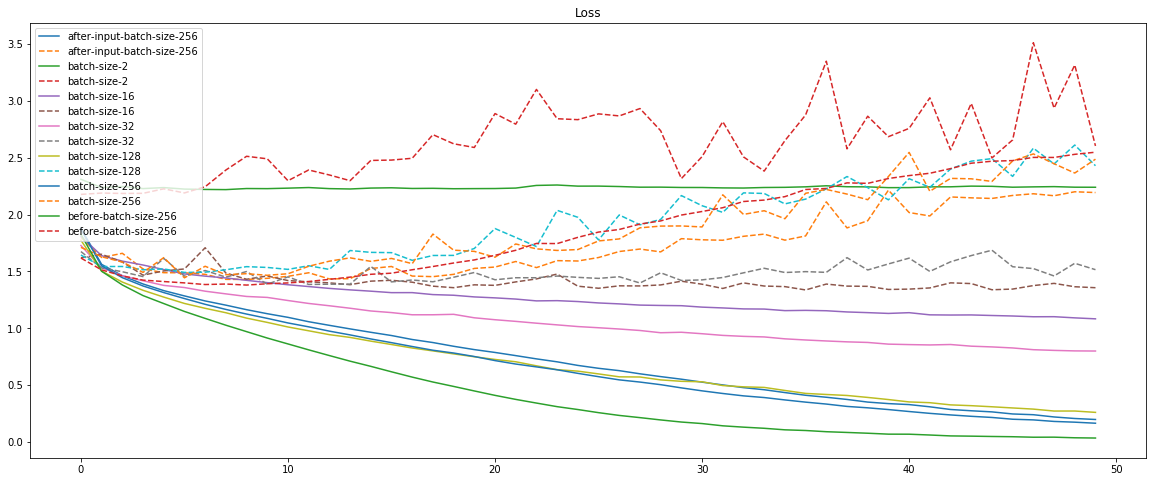

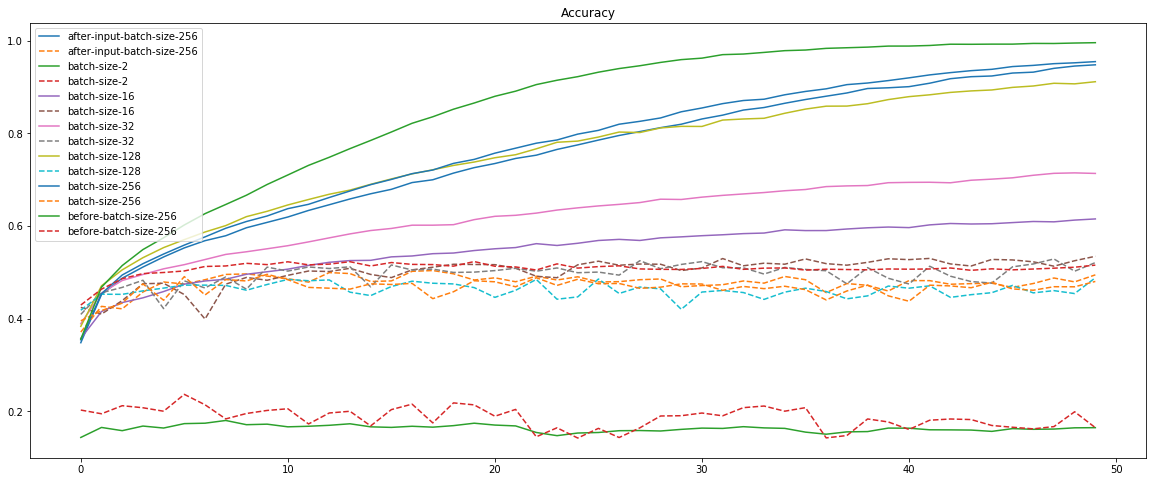

In [19]:
"""Code Here
將結果繪出
"""

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond)
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond)
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(20,8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond)
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond)
plt.title("Accuracy")
plt.legend()
plt.show()

**build_mlp_before為修正後補跑的，所以有error